# Exercise 03 Notebook - Text Classification with BERT
In this notebook we will create a Neural Network for Text Classification. As a basis for our Network we will use a pretrained BERT Model and just add a classification layer. We will train and test our dataset on the IMDB dataset we have already seen in the previous exercises.

## 1. Download the data, model , and tokenizer
In a first step we will install transformers, an awesome library by huggingface that implements a lot of transformer models and also provides pretrained models in many languages that we can download and use for free.

In [1]:
# install transformer library via pip
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Before we download a pretrained model, we download the data we will train our classifier on. Read the data from `https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv` into a pandas DataFrame.

In [2]:
# import pandas
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# Read the csv file and save it in a variable called data_df
data_df = pd.read_csv("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv")
data_df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [4]:
# After reading in the data, shuffle the rows of the DataFrame
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df.head()

,review,sentiment
0,A not so good action thriller because it unsuc...,0
1,Whether it's three guys in their tighty-whitey...,1
2,I had read a few positive reviews of this film...,0
3,"OK, if I was in the rental store and someone a...",0
4,It's hard to top this movie in several ways. E...,1


If you forget how the dataset looks like to a little bit of of data exploration

In [5]:
# Data Exploration
data_df.shape

(50000, 2)

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


A lot of errors can happen when you build your dataset and model for the first time. It neat little trick is to not use all of your data from the beginning. The IMDB dataset we use has 50,000 training examples. To see if everything works we dont need to use all of our data. A small subset is enough, so it might be useful to just take 1000 examples at first and only use the full data at the very end when we no that everything works as intended.

In [7]:
# FOR TESTING:
# remove the comment to get the first 1000 rows of the dataframe

# data_df = data_df.head(1000)

In [8]:
# Make an 80:20 split for training and validation data and save
# them as train_df and val_df, respectively.
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data_df, test_size=0.2)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [9]:
print("Training Size: "+str(len(train_df)))
print("Validation Size: "+str(len(val_df)))

Training Size: 40000
Validation Size: 10000


Great! Now that we have our data at hand we will now download the pretrained BERT Model. To be more precise we will use a smaller version of BERT named DistilBERT which is a lot smaller than the normnal BERT model but has 95% of it's performance.



> The DistilBERT model was proposed in the blog post Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT, and the paper DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

A smaller model allows much faster training and it makes much sense to try out ideas with a smaller model, because we can iterate much faster with a smaller model.

In [10]:
# import model and tokenizer classes
from transformers import DistilBertModel, DistilBertTokenizer

The transformer library makes it very easy for us to download pretrained versions of a model and the corresponding tokenizer. You can find a pretrained model [here](https://huggingface.co/distilbert-base-uncased). You could try out more models.

As already mentioned we want to use DistilBert for our classifier. Try to find a suitable model that we can use for our dataset and save it's name as a string in a variable:

In [11]:
# insert model name
model_name = "distilbert-base-uncased"

In [12]:
bert_model = DistilBertModel.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 2. Tokenizer
After successfully downloading the pretrained model and tokenizer will use the  tokenizer to tokenize our text data.

### 2.1 Getting familiar with the tokenizer

As a little warm-up lets do a few exercises on the example text given below. If you don't know what to do have a look at the [tokenizer documentation](https://huggingface.co/transformers/main_classes/tokenizer.html).

In [13]:
example_text = """Star wars made epic fantasy real. For a generation of people it has defined what the cinema experience is meant to be."""

In [14]:
# tokenize the example_text
# you should receive a list ['Star', 'wars', 'made', ..., '.']
# first we build a list of tokens from the sentence 
example_list = tokenizer.tokenize(example_text)
example_list

['star',
 'wars',
 'made',
 'epic',
 'fantasy',
 'real',
 '.',
 'for',
 'a',
 'generation',
 'of',
 'people',
 'it',
 'has',
 'defined',
 'what',
 'the',
 'cinema',
 'experience',
 'is',
 'meant',
 'to',
 'be',
 '.']

In [15]:
# encode the example text.
# you should receive a list of integers [101, 2537, 8755, ..., 102]
# save the list into a variable encoded_text
# The IDs we get are from the pretrained model that already has a list of token-ID pairs
encoded_text = tokenizer.encode(example_list)
encoded_text

[101,
 2732,
 5233,
 2081,
 8680,
 5913,
 2613,
 1012,
 2005,
 1037,
 4245,
 1997,
 2111,
 2009,
 2038,
 4225,
 2054,
 1996,
 5988,
 3325,
 2003,
 3214,
 2000,
 2022,
 1012,
 102]

In [16]:
# use the tokenizer to decode the encoded_text
# do you notice something?
decoded_text = tokenizer.decode(encoded_text)
print(decoded_text)
print("We notice the 'CLS' (token 101) and 'SEP' (token 102) Values in the front and in the back.")

[CLS] star wars made epic fantasy real. for a generation of people it has defined what the cinema experience is meant to be. [SEP]
We notice the 'CLS' (token 101) and 'SEP' (token 102) Values in the front and in the back.


In [17]:
# use the tokenizer object as a function and use the
# example_text as the input. What type of object do you receive?
# What does each value mean?

print(tokenizer(example_text))
print(type(tokenizer(example_text)))
# https://huggingface.co/transformers/v3.2.0/glossary.html#input-ids fand ich hilfreich
print("We receive an object that has the IDs and an attention mask.") 
print("Each ID is a token index, numerical representations of tokens that are already stored in the pretrained model")
print("CLS stands for Classification, SEP seperates a sentence from a new one")
print("For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.")

{'input_ids': [101, 2732, 5233, 2081, 8680, 5913, 2613, 1012, 2005, 1037, 4245, 1997, 2111, 2009, 2038, 4225, 2054, 1996, 5988, 3325, 2003, 3214, 2000, 2022, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
<class 'transformers.tokenization_utils_base.BatchEncoding'>
We receive an object that has the IDs and an attention mask.
Each ID is a token index, numerical representations of tokens that are already stored in the pretrained model
CLS stands for Classification, SEP seperates a sentence from a new one
For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.


### 2.2 Tokenizing the data
We are now ready to tokenize our test and validation dataset. Again use the tokenizer to create input_ids and attention_masks for the test and validation set. The tokenized text should have the following properties:
* [CLS] and [SEP] token added
* max length should be 128
* texts with more than 128 tokens should be truncated
* the tokenizer should return torch tensors.


In [18]:
# Apply the tokenizer to the training text data and save the resulting dict
# in a variable called tokenized_val_data // Nehme mal an das hier war ein Fehler in der Aufgabenstellung

tokenized_train_data = tokenizer(list(train_df["review"]), return_tensors='pt', truncation=True, padding=True, max_length=128)
tokenized_train_data

{'input_ids': tensor([[ 101, 2069, 5815,  ..., 1996, 1005,  102],
        [ 101, 2086, 3283,  ..., 1999, 2026,  102],
        [ 101, 1000, 2132,  ..., 1037, 2502,  102],
        ...,
        [ 101, 2023, 3185,  ..., 2177, 1997,  102],
        [ 101, 2444, 1037,  ..., 1998, 2009,  102],
        [ 101, 1045, 2293,  ..., 2006, 1998,  102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [19]:
# Apply the tokenizer to the validation text data and save the resulting dict
# in a variable called tokenized_train_data // Nehme mal an das hier war ein Fehler in der Aufgabenstellung
tokenized_val_data = tokenizer(list(val_df["review"]), return_tensors='pt', truncation=True, padding=True, max_length=128)
tokenized_val_data

{'input_ids': tensor([[  101,  1045,  2387,  ...,     0,     0,     0],
        [  101,  2023,  3185,  ...,     0,     0,     0],
        [  101, 22953,  2094,  ..., 21146,  4103,   102],
        ...,
        [  101,  2074,  3427,  ...,  3154,  1007,   102],
        [  101,  1026,  7987,  ...,     0,     0,     0],
        [  101,  4406,  2203,  ...,  7987,  1013,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [20]:
# have a look at the input_ids of the tokenized_train_data
tokenized_train_data["input_ids"]

tensor([[ 101, 2069, 5815,  ..., 1996, 1005,  102],
        [ 101, 2086, 3283,  ..., 1999, 2026,  102],
        [ 101, 1000, 2132,  ..., 1037, 2502,  102],
        ...,
        [ 101, 2023, 3185,  ..., 2177, 1997,  102],
        [ 101, 2444, 1037,  ..., 1998, 2009,  102],
        [ 101, 1045, 2293,  ..., 2006, 1998,  102]])

In [21]:
# have a look at the attention_mask of the tokenized_train_data
tokenized_train_data["attention_mask"]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

## 3. Creating the test and validation Dataset and DataLoader
Our train and evaluation data in vector format and we can now use the tokenized text to create our Dataset and DataLoader class

In [22]:
import torch
import torch.nn as nn
# import Dataset and DataLoader class
from torch.utils.data import Dataset, DataLoader

Now create a Dataset class called TextDataset. As always we will need to implement three functions:
* `__init__`
* `__len__`
* `__getitem__`

The `__init__` function should take tokenized data and the labels as arguments
and store them into the class variables `X` and `Y`

The `__len__` function should return the length of the dataset

The `__getitem__` should take index as input and return a tuple of data that looks like this `(input_ids, attention_mask, labels)`


In [23]:
class TextDataset(Dataset):

  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
  
  def __len__(self,):
    return len(self.Y)

  def __getitem__(self, index):
    return (self.X["input_ids"][index], self.X["attention_mask"][index], self.Y[index])

Create a `train_dataset` and `val_dataset`:

In [24]:
train_dataset = TextDataset(tokenized_train_data, train_df["sentiment"])
val_dataset = TextDataset(tokenized_val_data, val_df["sentiment"])

In [25]:
train_dataset[0]

(tensor([  101,  2069,  5815,  2000,  1996,  7165,  1997,  2111,  2040,  8357,
          2023,  2000,  2022,  1005,  4895,  5596, 21564,  3085,  1005,  1045,
          2097,  2110,  1996,  2206,  2302, 15192,  1996,  5793, 21407, 24250,
          3090,  2011,  2070,  1997,  1996,  2060, 15957,  1024,  1996,  1000,
          2143,  1000,  2003,  2915,  2006,  2678,  1006,  2054,  2828,  1997,
          4950,  1045,  2123,  1005,  1056,  2113,  1007,  2021,  1996,  4950,
          2386,  2018,  2009,  2006,  8285, 14876,  7874,  1006,   999,  1007,
          2035,  1996,  2051,  1010,  2061,  2008,  2151,  7263,  2929,  3084,
          2009,  2175,  1999,  1998,  2041,  1997,  3579,  1012,  1999,  2116,
          1997,  1996,  5019,  1996,  5889,  3209,  2175,  2041,  1997,  3579,
          2005,  2037,  5019,  1012,  2023,  2894, 11652,  1000,  5515,  1000,
          1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1045,
          2036,  4384,  2008,  2041,  1999,  1996,  

Create the training DataLoader `train_dl` and the validation DataLoader `val_dl` with a batch size of 32:

In [26]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [27]:
train_dl

# 4. Creating the Model
In this part we will create our model using the pretrained DistilBert model that we downloaded at the beginning. Before we add our classifier to the network we first need to understand what exactly the DistilBert models output looks like.

### 4.1 Understanding BERT's output

In [28]:
# get the first batch from our train_dl
first_batch = next(iter(train_dl))

Have a look at the `first_batch`. 

In [29]:
# first batch
first_batch

[tensor([[  101, 13576,  2000,  ...,  1012,  2002,   102],
         [  101,  2298,  1010,  ...,  1037,  4438,   102],
         [  101,  1045,  4149,  ...,  1996,  5557,   102],
         ...,
         [  101,  1045,  3728,  ...,  1010,  2021,   102],
         [  101, 10166,  1010,  ...,  7987,  1013,   102],
         [  101,  1000, 19924,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 1, 0, 0, 1])]

Save the input ids in a variable called `input_ids` and the attention mask into an variable called `attention_mask`. You can ignore the labels for now.

In [30]:
input_ids = first_batch[0]
input_ids

tensor([[  101, 13576,  2000,  ...,  1012,  2002,   102],
        [  101,  2298,  1010,  ...,  1037,  4438,   102],
        [  101,  1045,  4149,  ...,  1996,  5557,   102],
        ...,
        [  101,  1045,  3728,  ...,  1010,  2021,   102],
        [  101, 10166,  1010,  ...,  7987,  1013,   102],
        [  101,  1000, 19924,  ...,     0,     0,     0]])

In [31]:
attention_mask = first_batch[1]
attention_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])

In the first chapter we downloaded the pretrained DistilBert Model and saved it as `bert_model`. For the forward propagation the `bert_model`expects input ids and attention masks as an input. [This blog](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) post is a very nice visualization and is very helpful for understanding coming out of the bert model.

![Last hidden state](https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png)

In [32]:
last_hidden_state = bert_model(input_ids, attention_mask)

Check the dimension of the models output and make sure you understand what each dimension represents. Slice the model so that you get all values for each `[CLS]` token in the batch

In [33]:
# shape of last hidden state
last_hidden_state[0].shape

torch.Size([32, 128, 768])

In [34]:
# Select [CLS] Token
# CLS Token is the first position
last_hidden_state[0][:,0,:]

tensor([[-0.2453, -0.1459, -0.2442,  ...,  0.1471,  0.3280,  0.2470],
        [ 0.3451, -0.2022, -0.0219,  ..., -0.1738,  0.6373,  0.2287],
        [ 0.0793, -0.0746, -0.1523,  ..., -0.0413,  0.4665,  0.2673],
        ...,
        [ 0.1495, -0.2639, -0.0967,  ..., -0.0303,  0.4130,  0.3608],
        [ 0.0790,  0.0370,  0.0137,  ..., -0.0948,  0.4720,  0.3284],
        [-0.0808, -0.2469,  0.0037,  ..., -0.1047,  0.6441,  0.1435]],
       grad_fn=<SliceBackward0>)

In [35]:
# check the shape of the [CLS] tokens
last_hidden_state[0][:,0,:].shape

torch.Size([32, 768])

### 4.2 Defining the Model
Now create a neural network called `BertClassifier`. The constructor should receive the pretrained bert model and the number of classes.
In the constructor save the bert model into a variable `bert`. Create a linear layer and think which input and output dimensions are needed.

The `forward()` should receive `input_ids` and `attention_mask` as input and should propate them through the layers.

In [66]:
# implement BertClassifier
class BertClassifier(nn.Module):

  def __init__(self, bert_model, n_classes):
    super().__init__()
    self.bert = bert_model
    self.l1 = nn.Linear(768, n_classes)
    self.activation = nn.Sigmoid() # Sigmoid is recommended for binary tasks 

  def freeze_bert(self):
    for param in self.bert.parameters():
      param.requires_grad = False


  def forward(self, input_ids, attention_mask):
    # feed input to bert
    X = self.bert(input_ids, attention_mask)
    # extract [CLS] for the classification
    X = X.last_hidden_state[:, 0, :]
    X = self.l1(X)
    X = self.activation(X)
    return X

In [67]:
# instiantiate the model
model = BertClassifier(bert_model=bert_model, n_classes=1)

## 5. Model Training
After defining the model we now have everything we need to train our model.

### 5.1 Moving to the GPU

In previous exercises our models were quite small with only a couple of thousand parameters. Our BERT classifier is several magnitudes larger (about 66M parameters). With that many parameters it becomes necessary to train on the gpu.

We can easily move our model to the gpu with the following command:
  `model.to('gpu')`. But there is one problem. If there is no 'gpu' available the code will crash. There is an easy way to check if a gpu is available:
  

In [68]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

We can now move our model to the gpu safely. If there is no gpu available the model just stays on the cpu.

In [69]:
# pass the model to the gpu
model.to(DEVICE)

BertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

### 5.2 Setting up the training

In [70]:
import torch

epochs = 20
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_func = nn.BCELoss()  # Binary Cross Entropy Loss

In [71]:
# To get a better idea of how well your model performs
# you should implement an accuracy function that is
# called after each epoch of your training loop
def accuracy(out, yb):
    preds = out >= 0.5
    return (preds == yb).float().mean()

In [72]:
# Freezing Parameters of bert

model.freeze_bert()

### 5.3 Train the model
The training loop is almost the same as in the first exercise of the course. Spot and understand the differences

In [73]:
def train(net, train_dl, val_dl , epochs, optimizer, loss_func):
    # set the model on train mode
    net.train()
    # define arrays for evaluation
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    # loop over all epochs
    for epoch in tqdm(range(epochs)):
        # reset evaluation variables
        train_loss, valid_loss = 0, 0
        train_acc, valid_acc = 0, 0        
        # training loop
        for step, batch in enumerate(train_dl):            
            # push batch to gpu
            input_ids, attention_mask, labels = [x.to(DEVICE) for x in batch]                   
            # predict
            y_hat = net(
                input_ids=input_ids,
                attention_mask=attention_mask
            )            
            # calculate loss and adjust weights
            labels = labels.unsqueeze(1).float() # reshape target tensor        
            loss = loss_func(y_hat, labels)
            # zero the all gradients
            # calc gradients
            loss.backward()
            # update weights
            optimizer.step()
            # reset optimizer
            optimizer.zero_grad()
            # calculate evaluation kpis
            train_loss += loss
            train_acc  += accuracy(y_hat, labels) 

        net.eval()
        # valiadation loop
        with torch.no_grad():
          for step, batch in enumerate(val_dl):
            # push batch to gpu
            input_ids, attention_mask, labels = [x.to(DEVICE) for x in batch]
            # predict
            y_hat = net(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # calculate evaluation kpis
            labels = labels.unsqueeze(1).float() # reshape target tensor
            loss = loss_func(y_hat, labels)
            valid_loss += loss
            valid_acc  += accuracy(y_hat, labels)
            

        # calculations for evaluations
        train_loss /= len(train_dl)
        train_acc  /= len(train_dl)
        valid_loss /= len(val_dl)
        valid_acc  /= len(val_dl)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)


        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTraining Acc: {train_acc:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Acc: {valid_acc:.6f}')

    # return losses for plotting  
    return train_losses, valid_losses, train_accs, valid_accs

In [74]:
# Execute the train function and train the model.
train_losses, valid_losses, train_accs, valid_accs = train(model, train_dl, val_dl, epochs, optimizer, loss_func)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.501443 	Training Acc: 0.769750 	Validation Loss: 0.444568 	Validation Acc: 0.795727
Epoch: 2 	Training Loss: 0.434643 	Training Acc: 0.801075 	Validation Loss: 0.422984 	Validation Acc: 0.808906
Epoch: 3 	Training Loss: 0.424340 	Training Acc: 0.807250 	Validation Loss: 0.416522 	Validation Acc: 0.809804
Epoch: 4 	Training Loss: 0.419065 	Training Acc: 0.809925 	Validation Loss: 0.412890 	Validation Acc: 0.811701
Epoch: 5 	Training Loss: 0.415622 	Training Acc: 0.811800 	Validation Loss: 0.414829 	Validation Acc: 0.811801
Epoch: 6 	Training Loss: 0.413123 	Training Acc: 0.812725 	Validation Loss: 0.409591 	Validation Acc: 0.813099
Epoch: 7 	Training Loss: 0.411293 	Training Acc: 0.814150 	Validation Loss: 0.406162 	Validation Acc: 0.815395
Epoch: 8 	Training Loss: 0.409513 	Training Acc: 0.814975 	Validation Loss: 0.405188 	Validation Acc: 0.815695
Epoch: 9 	Training Loss: 0.408082 	Training Acc: 0.815150 	Validation Loss: 0.405394 	Validation Acc: 0.814397
E

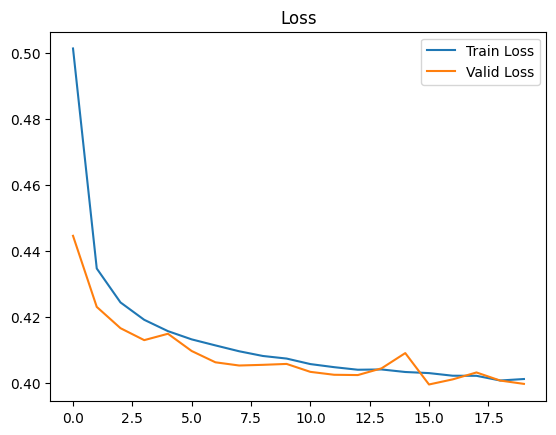

In [75]:
func = lambda x : x.cpu().item()

plt.title("Loss")
plt.plot(list(map(func, train_losses)), label='Train Loss')
plt.plot(list(map(func, valid_losses)), label='Valid Loss')
plt.legend()
plt.show()

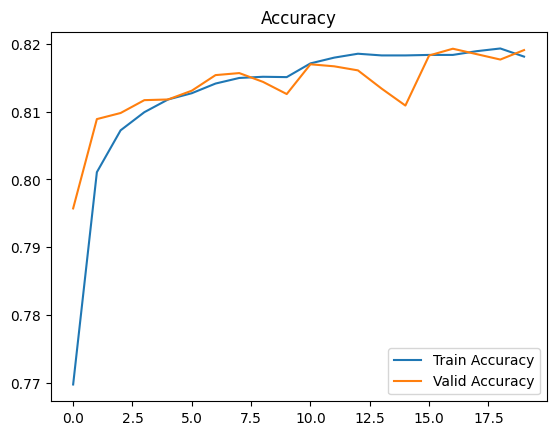

In [76]:
plt.title("Accuracy")
plt.plot(list(map(func, train_accs)), label='Train Accuracy')
plt.plot(list(map(func, valid_accs)), label='Valid Accuracy')
plt.legend()
plt.show()